In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import pandas as pd

from bambi.plots import plot_cap

## Gaussian Linear Model

For the first demonstration, we will use a Gaussian linear regression model to better understand the `plot_cap` function and its arguments. 

In [329]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
#data["drat"] = pd.Categorical(data["drat"], ordered=True).codes

# Define and fit the Bambi model
model = bmb.Model("mpg ~ hp * drat * am", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, drat, hp:drat, am, hp:am, drat:am, hp:drat:am]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [330]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,13.199,13.415,-13.335,37.366,0.354,0.251,1435.0,1685.0,1.00
hp,-0.014,0.084,-0.179,0.141,0.002,0.002,1331.0,1775.0,1.01
drat,3.735,3.797,-3.023,11.266,0.101,0.073,1410.0,1726.0,1.00
hp:drat,-0.012,0.025,-0.057,0.037,0.001,0.000,1348.0,1806.0,1.00
am,2.029,14.087,-22.234,30.039,0.358,0.253,1550.0,2032.0,1.00
hp:am,0.055,0.089,-0.112,0.220,0.002,0.002,1469.0,2046.0,1.00
drat:am,0.357,3.614,-6.505,6.869,0.098,0.069,1357.0,1737.0,1.00
hp:drat:am,-0.013,0.025,-0.056,0.035,0.001,0.000,1378.0,2069.0,1.00
mpg_sigma,3.079,0.449,2.311,3.940,0.009,0.006,2715.0,2410.0,1.00


In [324]:
data.head(3)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,medium,160.0,110,15,2.620,16.46,0,1,B,4
1,21.0,medium,160.0,110,15,2.875,17.02,0,1,B,4
2,22.8,low,108.0,93,14,2.320,18.61,1,1,B,1


In [331]:
datagrid_1 = pd.DataFrame({
    "hp": data.hp,
    "drat": data.drat,
    "am": data.am
})

datagrid_2 = pd.DataFrame({
    "hp": data.hp + 0.01,
    "drat": data.drat,
    "am": data.am
})

In [332]:
# original
preds = model.predict(idata, data=datagrid_1, kind="mean", inplace=False)
preds_mu = preds.posterior.mpg_mean.mean(("chain", "draw"))

# datagrid preds
grid_preds = model.predict(idata, data=datagrid_2, kind="mean", inplace=False)
grid_preds_mu = grid_preds.posterior.mpg_mean.mean(("chain", "draw"))

# comparisons
comparisons = preds_mu - grid_preds_mu
comparisons_std = np.std(comparisons).to_numpy()

In [333]:
comparisons_df = pd.DataFrame({
    "drat": data.drat,
    "upper": comparisons + comparisons_std,
    "lower": comparisons - comparisons_std,
    "am": data.am,
    "comparisons": comparisons,
    "preds_mu": preds_mu,
    "grid_preds_mu": grid_preds_mu
})

comparisons_df = comparisons_df.sort_values(by="drat").reset_index(drop=True)

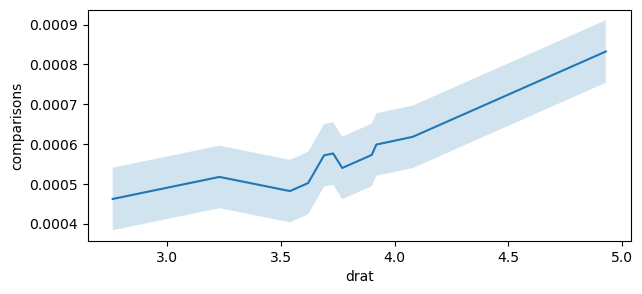

In [334]:
plt.figure(figsize=(7, 3))
sns.lineplot(x=comparisons_df.drat, y=comparisons_df.comparisons)
plt.fill_between(comparisons_df.drat, comparisons_df.upper, comparisons_df.lower, alpha=0.2)

In [42]:
comparisons

<xarray.DataArray 'mpg_mean' (mpg_obs: 32)>
array([-0.02863472, -0.02863472, -0.02800395, -0.02498797, -0.02540033,
       -0.02310288, -0.02575379, -0.02858142, -0.02993632, -0.02993632,
       -0.02993632, -0.02492906, -0.02492906, -0.02492906, -0.02410434,
       -0.0245167 , -0.0258716 , -0.03090547, -0.04162848, -0.03267161,
       -0.02864032, -0.02310288, -0.02540033, -0.02881705, -0.02498797,
       -0.03090547, -0.03532083, -0.02699473, -0.03267161, -0.02510243,
       -0.02409321, -0.03128393])
Coordinates:
  * mpg_obs  (mpg_obs) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31

In [102]:
# Define and fit the Bambi model
model = bmb.Model("mpg ~ hp * wt", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, wt, hp:wt]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [103]:
# original
preds = model.predict(idata, kind="mean", inplace=False)
mean_preds = preds.posterior.mpg_mean.mean(("chain", "draw"))
mean_std = preds.posterior.mpg_mean.std(("chain", "draw"))

In [104]:
new_grid = {
    'hp': data.hp + 10, 
    'wt': data.wt
    }
new_grid = pd.DataFrame.from_dict(new_grid)

In [106]:
preds_new = model.predict(
    idata,
    "mean",
    new_grid,
    inplace=False
)

mean_preds_new = preds_new.posterior.mpg_mean.mean(("chain", "draw"))
mean_std_new = preds_new.posterior.mpg_mean.std(("chain", "draw"))

In [143]:
diff = mean_preds_new - mean_preds
std = np.std(diff) # really the average std

In [135]:
comparison_df = pd.DataFrame({
    "diff": diff,
    "upper": diff + std.to_numpy(),
    "lower": diff - std.to_numpy(),
    "wt": data.wt
})
comparison_df = comparison_df.sort_values(by="wt").reset_index(drop=True)

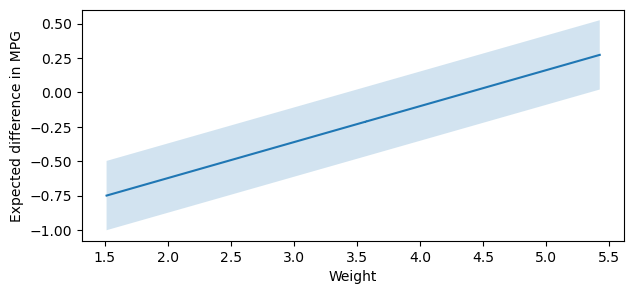

In [137]:
plt.figure(figsize=(7, 3))
plt.plot(comparison_df.wt, comparison_df["diff"])
plt.fill_between(
    comparison_df.wt,
    comparison_df["upper"],
    comparison_df["lower"],
    alpha=0.2
)
plt.xlabel("Weight")
plt.ylabel("Expected difference in MPG");

### Palmer penguins

In [69]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/palmerpenguins/penguins.csv", index_col=0)

In [70]:
data = data.dropna(axis=0, how="any")

In [123]:
model = bmb.Model(
    "body_mass_g ~ flipper_length_mm * species * bill_length_mm + island",
    data, family="gaussian"
)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, Intercept, flipper_length_mm, species, flipper_length_mm:species, bill_length_mm, flipper_length_mm:bill_length_mm, species:bill_length_mm, flipper_length_mm:species:bill_length_mm, island]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.


In [124]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-6621.982,4994.819,-15950.763,2714.231,131.516,93.015,1442.0,2000.0,1.0
flipper_length_mm,39.260,26.228,-8.793,88.782,0.691,0.488,1441.0,2043.0,1.0
species[Chinstrap],358.032,2530.608,-4014.266,5460.335,60.581,42.844,1753.0,2431.0,1.0
species[Gentoo],-1941.339,2334.832,-6366.018,2371.530,57.724,41.311,1640.0,2117.0,1.0
flipper_length_mm:species[Chinstrap],3.917,13.561,-21.860,28.714,0.322,0.228,1772.0,2432.0,1.0
flipper_length_mm:species[Gentoo],10.627,10.799,-10.355,29.883,0.243,0.172,1964.0,2438.0,1.0
bill_length_mm,146.651,124.190,-77.265,382.820,3.329,2.354,1393.0,1808.0,1.0
flipper_length_mm:bill_length_mm,-0.380,0.648,-1.628,0.784,0.017,0.012,1383.0,1836.0,1.0
species:bill_length_mm[Chinstrap],-51.932,55.145,-157.283,48.558,1.328,0.939,1725.0,2259.0,1.0
species:bill_length_mm[Gentoo],-18.541,49.308,-110.659,73.099,1.159,0.820,1817.0,2149.0,1.0


In [125]:
datagrid_1 = pd.DataFrame({
    "flipper_length_mm": [172],
    "species": ["Adelie"],
    "bill_length_mm": [data.bill_length_mm.mean()],
    "island": ["Biscoe"]
})

datagrid_2 = pd.DataFrame({
    "flipper_length_mm": [172],
    "species": ["Gentoo"],
    "bill_length_mm": [data.bill_length_mm.mean()],
    "island": ["Biscoe"]
})

datagrid_3 = pd.DataFrame({
    "flipper_length_mm": [172],
    "species": ["Chinstrap"],
    "bill_length_mm": [data.bill_length_mm.mean()],
    "island": ["Biscoe"]
})

datagrid_4 = pd.DataFrame({
    "flipper_length_mm": 231,
    "species": ["Adelie"],
    "bill_length_mm": [data.bill_length_mm.mean()],
    "island": ["Biscoe"]
})

datagrid_5 = pd.DataFrame({
    "flipper_length_mm": 231,
    "species": ["Gentoo"],
    "bill_length_mm": [data.bill_length_mm.mean()],
    "island": ["Biscoe"]
})

datagrid_6 = pd.DataFrame({
    "flipper_length_mm": 231,
    "species": ["Chinstrap"],
    "bill_length_mm": [data.bill_length_mm.mean()],
    "island": ["Biscoe"]
})

In [126]:
# define a function that predicts on each grid and returns the predictions in a dictionary with the grid number as the key
def get_preds(idata, model, grids):
    preds = {}
    for i, grid in enumerate(grids):
        preds[i] = model.predict(idata, data=grid, kind="mean", inplace=False)
        preds[i] = preds[i].posterior.body_mass_g_mean.mean(("chain", "draw")).to_numpy()[0]
    return preds

In [127]:
preds = get_preds(idata, model, [datagrid_1, datagrid_2, datagrid_3, datagrid_4, datagrid_5, datagrid_6])

In [128]:
# create a dataframe with the data grids and the predictions
preds_df = pd.DataFrame({
    "flipper_length_mm": [172, 172, 172, 231, 231, 231],
    "species": ["Adelie", "Gentoo", "Chinstrap", "Adelie", "Gentoo", "Chinstrap"],
    "bill_length_mm": [data.bill_length_mm.mean(), data.bill_length_mm.mean(), data.bill_length_mm.mean(), data.bill_length_mm.mean(), data.bill_length_mm.mean(), data.bill_length_mm.mean()],
    "island": ["Biscoe", "Biscoe", "Biscoe", "Biscoe", "Biscoe", "Biscoe"],
    "preds": [preds[0], preds[1], preds[2], preds[3], preds[4], preds[5]]
})

preds_df

,flipper_length_mm,species,bill_length_mm,island,preds
0,172,Adelie,43.992793,Biscoe,3708.430635
1,172,Gentoo,43.992793,Biscoe,3257.691390
2,172,Chinstrap,43.992793,Biscoe,2893.014523
3,231,Adelie,43.992793,Biscoe,5038.961109
4,231,Gentoo,43.992793,Biscoe,5379.331787
5,231,Chinstrap,43.992793,Biscoe,4604.714846


In [129]:
species = pd.DataFrame(preds_df["species"].drop_duplicates().reset_index(drop=True))
species

,species
0,Adelie
1,Gentoo
2,Chinstrap


In [130]:
difference_df = pd.DataFrame(preds_df.groupby(["species"])["preds"].diff(1).dropna().reset_index(drop=True))
difference_df["species"] = species

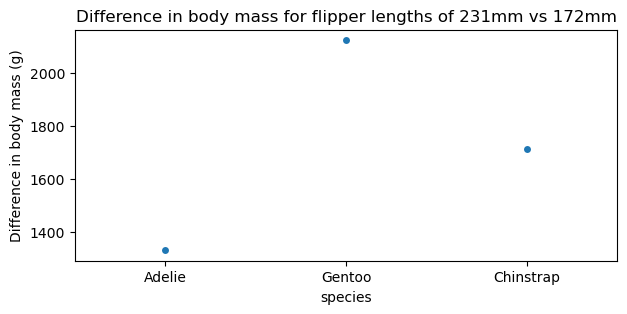

In [143]:
plt.figure(figsize=(7, 3))
sns.stripplot(
    x="species",
    y="preds",
    data=difference_df,
    jitter=False,
    dodge=True
)
plt.ylabel("Difference in body mass (g)")
plt.title("Difference in body mass for flipper lengths of 231mm vs 172mm");

In [138]:
# datagrid_obs = pd.DataFrame({
#     "flipper_length_mm": data.flipper_length_mm,
#     "species": data.species,
#     "bill_length_mm": data.bill_length_mm,
#     "island": data.island.mode().to_numpy()[0]
# })

# preds = model.predict(idata, kind="mean", inplace=False)
# preds_mu = preds.posterior.body_mass_g_mean.mean(("chain", "draw"))

datagrid = pd.DataFrame({
    "flipper_length_mm": data.flipper_length_mm,
    "species": data.species,
    "bill_length_mm": data.bill_length_mm,
    "island": data.island.mode().to_numpy()[0]
})

grid_preds = model.predict(idata, data=datagrid, kind="mean", inplace=False)
grid_preds_mu = grid_preds.posterior.body_mass_g_mean.mean(("chain", "draw"))

In [349]:
preds_df = pd.DataFrame({
    "flipper_length_mm": data.flipper_length_mm,
    "species": data.species,
    "bill_length_mm": data.bill_length_mm,
    "comparison": compare,
    "obs_preds": preds_mu,
    "grid_preds": grid_preds_mu
})

#preds_df = preds_df.sort_values(by="bill_length_mm").reset_index(drop=True)

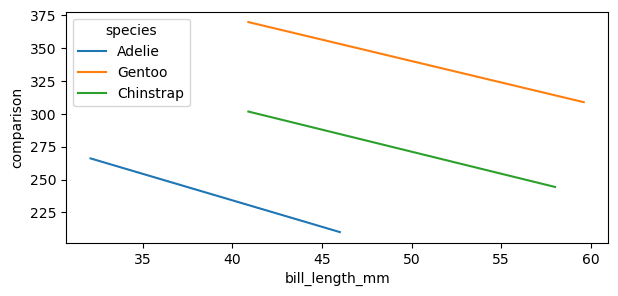

In [350]:
plt.figure(figsize=(7, 3))
sns.lineplot(
    x=preds_df.bill_length_mm,
    y=preds_df.comparison,
    hue=preds_df.species
);

### Titanic

In [2]:
dat = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", index_col=0)

In [3]:
dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["Sex"] = pd.Categorical(dat["Sex"]).codes

In [4]:
dat = dat.dropna(axis=0, how="any")

In [5]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age", 
    data=dat, 
    family="binomial"
)
idata = titanic_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Survived_sigma, Intercept, PClass, SexCode, PClass:SexCode, Age, PClass:Age, SexCode:Age, PClass:SexCode:Age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [7]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.799,0.098,0.611,0.977,0.003,0.002,1455.0,1728.0,1.00
PClass[2.0],-0.252,0.126,-0.486,-0.008,0.003,0.002,1460.0,1684.0,1.00
PClass[3.0],-0.494,0.119,-0.714,-0.266,0.003,0.002,1490.0,1864.0,1.01
SexCode,0.130,0.140,-0.134,0.393,0.004,0.003,1247.0,1548.0,1.00
PClass:SexCode[2.0],0.288,0.190,-0.076,0.634,0.005,0.004,1321.0,1769.0,1.00
PClass:SexCode[3.0],0.019,0.175,-0.301,0.355,0.005,0.003,1301.0,1321.0,1.00
Age,-0.011,0.002,-0.015,-0.007,0.000,0.000,1428.0,1792.0,1.00
PClass:Age[2.0],-0.002,0.003,-0.008,0.005,0.000,0.000,1524.0,1698.0,1.00
PClass:Age[3.0],0.005,0.003,-0.001,0.011,0.000,0.000,1637.0,2181.0,1.00
SexCode:Age,0.012,0.003,0.005,0.018,0.000,0.000,1275.0,1834.0,1.00


In [8]:
grid_50_1_3 = pd.DataFrame({
    "Age": [50],
    "SexCode": [1],
    "PClass": [3]
})

grid_50_1_1 = pd.DataFrame({
    "Age": [50],
    "SexCode": [1],
    "PClass": [1]
})

grid_50_0_3 = pd.DataFrame({
    "Age": [50],
    "SexCode": [0],
    "PClass": [3]
})

grid_50_0_1 = pd.DataFrame({
    "Age": [50],
    "SexCode": [0],
    "PClass": [1]
})

In [20]:
# define a function that predicts on each grid and returns the predictions in a dictionary with the grid number as the key
def get_preds(idata, grids):
    preds = {}
    for i, grid in enumerate(grids):
        preds[i] = titanic_model.predict(idata, data=grid, kind="mean", inplace=False)
        preds[i] = preds[i].posterior.Survived_mean.mean(("chain", "draw")).to_numpy()[0]
    return preds

In [21]:
preds = get_preds(idata, [grid_50_1_3, grid_50_1_1, grid_50_0_3, grid_50_0_1])

In [22]:
# diff. in probs. of survival
preds[0] - preds[1]

-0.5113357237457705

In [23]:
preds[2] - preds[3]

-0.2382496797478271

In [24]:
comparison_df = pd.DataFrame({
    "PClass": [3, 1, 3, 1],
    "SexCode": [1, 1, 0, 0],
    "Age": [50, 50, 50, 50],
    "Survival": [preds[0], preds[1], preds[2], preds[3]]
})
comparison_df

,PClass,SexCode,Age,Survival
0,3,1,50,0.446254
1,1,1,50,0.957590
2,3,0,50,0.007755
3,1,0,50,0.246004


In [43]:
focal = comparison_df[["SexCode", "Age"]].drop_duplicates().reset_index(drop=True)
focal

,SexCode,Age
0,1,50
1,0,50


In [55]:
compare_probs_df = pd.DataFrame(
    comparison_df.groupby(["SexCode", "Age"])['Survival'].diff(1).dropna().reset_index(drop=True),
    )
compare_probs_df[["SexCode", "Age"]] = focal

In [56]:
compare_probs_df

,Survival,SexCode,Age
0,0.511336,1,50
1,0.238250,0,50


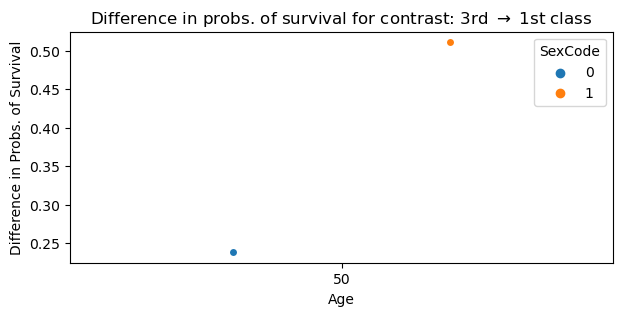

In [68]:
plt.figure(figsize=(7, 3))
sns.stripplot(
    x=compare_probs_df.Age,
    y=compare_probs_df.Survival,
    hue=compare_probs_df.SexCode,
    dodge=True,
    jitter=False
)
plt.title("Difference in probs. of survival for contrast: 3rd $\\rightarrow$ 1st class")
plt.ylabel("Difference in Probs. of Survival");